In [10]:
import pandas as pd
corpus = ['king is a strong man', 
          'queen is a wise woman', 
          'boy is a young man',
          'girl is a young woman',
          'prince is a young king',
          'princess is a young queen',
          'man is strong', 
          'woman is pretty',
          'prince is a boy will be king',
          'princess is a girl will be queen']

In [2]:
def remove_stop_words(corpus):
    stop_words = ['is', 'a', 'will', 'be']
    results = []
    for text in corpus:
        tmp = text.split(' ')
        for stop_word in stop_words:
            if stop_word in tmp:
                tmp.remove(stop_word)
        results.append(" ".join(tmp))
    
    return results

In [28]:
corpus

['king strong man',
 'queen wise woman',
 'boy young man',
 'girl young woman',
 'prince young king',
 'princess young queen',
 'man strong',
 'woman pretty',
 'prince boy king',
 'princess girl queen']

In [33]:
corpus = remove_stop_words(corpus)
words = set([word for text in corpus for word in text.split(' ')])
words

{'boy',
 'girl',
 'king',
 'man',
 'pretty',
 'prince',
 'princess',
 'queen',
 'strong',
 'wise',
 'woman',
 'young'}

In [37]:
word2int = {}
ONE_HOT_DIM = len(words)
# function to convert numbers to one hot vectors
def to_one_hot_encoding(data_point_index):
    one_hot_encoding = np.zeros(ONE_HOT_DIM)
    one_hot_encoding[data_point_index] = 1
    return one_hot_encoding

for i,word in enumerate(words):
    word2int[word] = to_one_hot_encoding(i)


WINDOW_SIZE = 2
sentences = [sentence.split() for sentence in corpus]
    
data = []
for sentence in sentences:
    for idx, word in enumerate(sentence):
        for neighbor in sentence[max(idx - WINDOW_SIZE, 0) : min(idx + WINDOW_SIZE, len(sentence)) + 1] : 
            if neighbor != word:
                data.append([word, neighbor])
df = pd.DataFrame(data, columns = ['input', 'label'])

In [38]:
X = [] # input word
Y = [] # target word

for x, y in zip(df['input'], df['label']):
    X.append(word2int[ x ])
    Y.append(word2int[ y ])
    
# convert them to numpy arrays
X_train = np.asarray(X)
Y_train = np.asarray(Y)


In [41]:
print(X_train.shape, Y_train.shape)

(52, 12)

In [58]:
import tensorflow.compat.v1 as tf
import numpy as np
tf.compat.v1.disable_eager_execution()



# making placeholders for X_train and Y_train
x = tf.placeholder(tf.float32, shape=(None, ONE_HOT_DIM))
y_label = tf.placeholder(tf.float32, shape=(None, ONE_HOT_DIM))

# word embedding will be 2 dimension for 2d visualization
EMBEDDING_DIM = 2 

# hidden layer: which represents word vector eventually
W1 = tf.Variable(tf.random_normal([ONE_HOT_DIM, EMBEDDING_DIM]))
b1 = tf.Variable(tf.random_normal([1])) #bias
hidden_layer = tf.add(tf.matmul(x,W1), b1)

# output layer
W2 = tf.Variable(tf.random_normal([EMBEDDING_DIM, ONE_HOT_DIM]))
b2 = tf.Variable(tf.random_normal([1]))
prediction = tf.nn.softmax(tf.add( tf.matmul(hidden_layer, W2), b2))
# loss function: cross entropy
loss = tf.reduce_mean(-tf.reduce_sum(y_label * tf.log(prediction), axis=[1]))
# training operation
optimizer = tf.train.GradientDescentOptimizer(learning_rate=0.05).minimize(loss)


sess = tf.Session()
init = tf.global_variables_initializer()
sess.run(init) 

iteration = 20000
for i in range(iteration):
    # input is X_train which is one hot encoded word
    # label is Y_train which is one hot encoded neighbor word
    sess.run(optimizer, feed_dict={x: X_train, y_label: Y_train})
    if i % 3000 == 0:
        print('iteration '+str(i)+' loss is : ', sess.run(loss, feed_dict={x: X_train, y_label: Y_train}))

iteration 0 loss is :  5.2197876
iteration 3000 loss is :  1.8077579
iteration 6000 loss is :  1.7502588
iteration 9000 loss is :  1.7049285
iteration 12000 loss is :  1.6867579
iteration 15000 loss is :  1.6774011
iteration 18000 loss is :  1.6709285


In [59]:
sess.run(W1)

array([[ 0.34677622,  1.478914  ],
       [ 2.4674206 ,  3.092782  ],
       [-0.2865011 , -4.3661933 ],
       [ 1.1267184 , -0.13277182],
       [ 1.3332033 ,  1.2238921 ],
       [ 0.14846481, -1.7605066 ],
       [-0.34905308,  1.7535836 ],
       [-3.2729423 ,  3.2146792 ],
       [-4.848386  ,  2.3125827 ],
       [ 1.3310258 , -5.2622786 ],
       [-0.8811957 ,  1.3163095 ],
       [ 1.1387769 ,  0.2729496 ]], dtype=float32)

In [61]:
sess.run(b1)

array([-1.102094], dtype=float32)

In [60]:
# Now the hidden layer (W1 + b1) is actually the word look up table
vectors = sess.run(W1 + b1)
w2v_df = pd.DataFrame(vectors, columns = ['x1', 'x2'])
w2v_df['word'] = words
w2v_df = w2v_df[['word', 'x1', 'x2']]
w2v_df

,word,x1,x2
0,queen,-0.755318,0.376820
1,pretty,1.365327,1.990688
2,prince,-1.388595,-5.468287
3,boy,0.024624,-1.234866
4,young,0.231109,0.121798
5,man,-0.953629,-2.862601
6,girl,-1.451147,0.651489
7,wise,-4.375036,2.112585
8,princess,-5.950480,1.210489
9,strong,0.228932,-6.364373


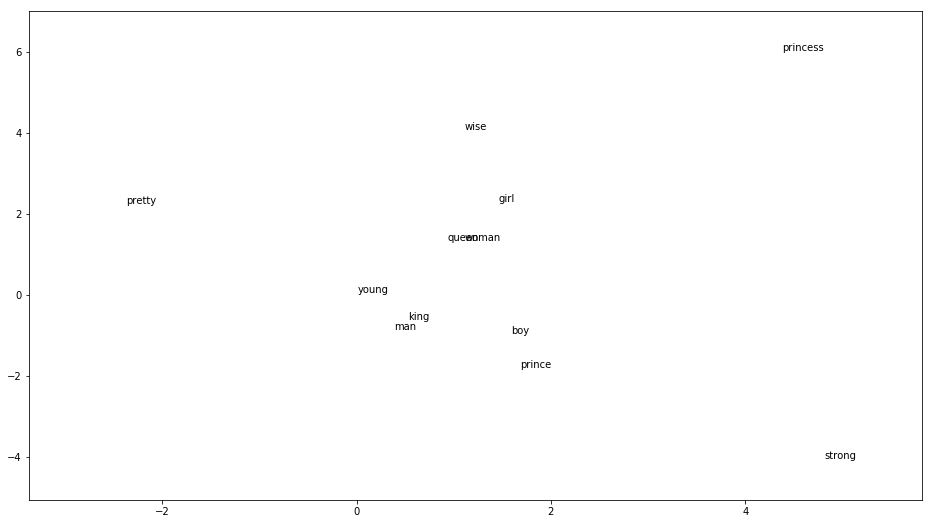

In [26]:
#word vector in 2d chart

import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(16, 9))

for word, x1, x2 in zip(w2v_df['word'], w2v_df['x1'], w2v_df['x2']):
    ax.annotate(word, (x1,x2 ))
    
PADDING = 1.0
x_axis_min = np.amin(vectors, axis=0)[0] - PADDING
y_axis_min = np.amin(vectors, axis=0)[1] - PADDING
x_axis_max = np.amax(vectors, axis=0)[0] + PADDING
y_axis_max = np.amax(vectors, axis=0)[1] + PADDING
 
plt.xlim(x_axis_min,x_axis_max)
plt.ylim(y_axis_min,y_axis_max)
plt.rcParams["figure.figsize"] = (10,10)

plt.show()